
Processing category: tops


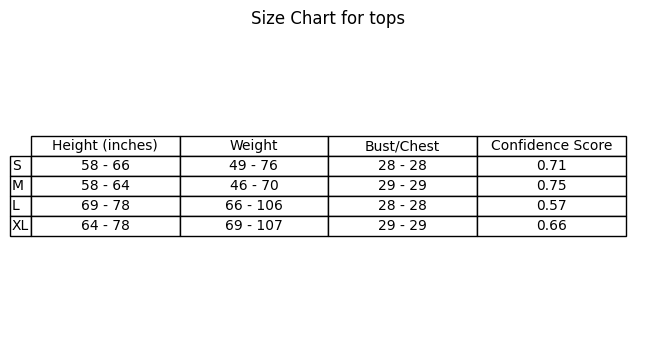

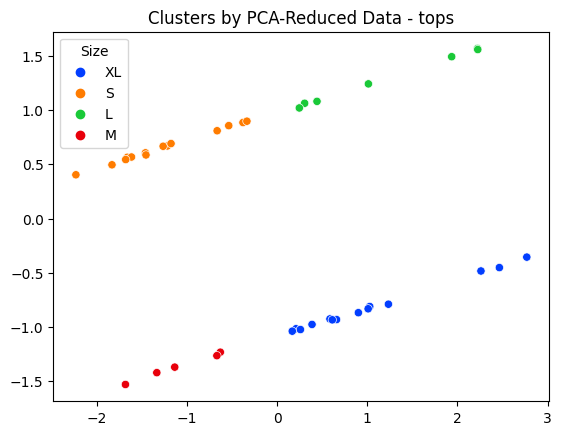


Processing category: bottoms


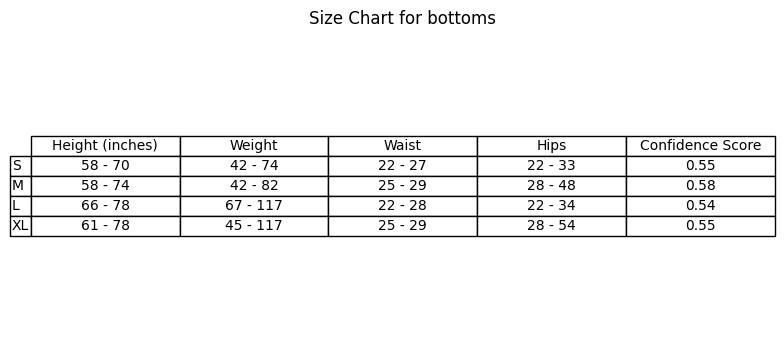

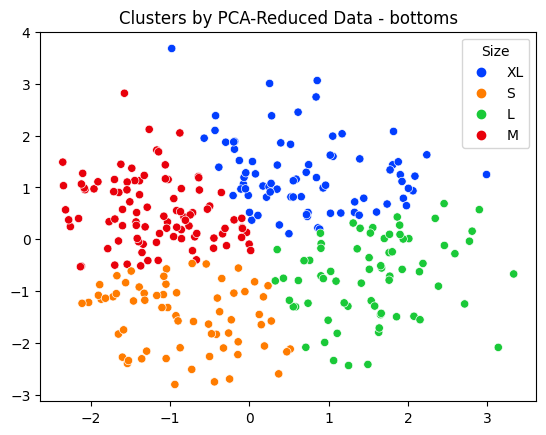


Processing category: dresses


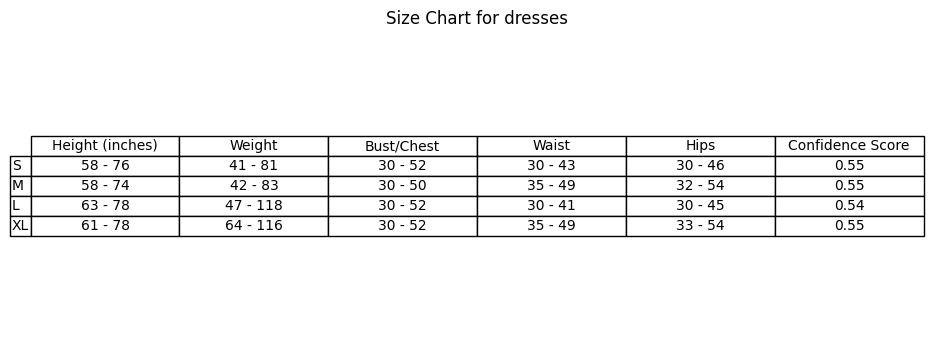

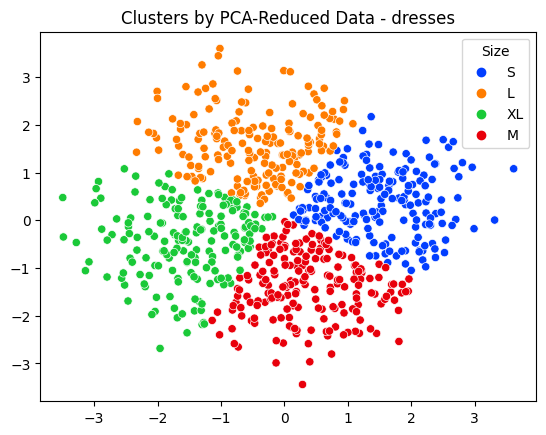

In [6]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, pairwise_distances
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import table

# Load existing dataset
def load_data(file_path):
    return pd.read_csv(file_path)

# Convert height from string format to numeric (in inches)
def height_to_inches(height):
    feet, inches = height.split("'")
    feet = int(feet)
    inches = int(inches.replace('"', ''))
    return feet * 12 + inches

# Preprocess data
def preprocess_data(data):
    data['Height (inches)'] = data['Height'].apply(height_to_inches)
    data = data.drop(columns=['Height'])
    data['Cup Size'] = data['Cup Size'].fillna('Unknown')
    data['Category'] = 'dresses'
    data.loc[data['Bust/Chest'] < 30, 'Category'] = 'tops'
    data.loc[data['Waist'] < 30, 'Category'] = 'bottoms'
    return data

# Define categories and their corresponding features
categories = {
    'tops': ['Height (inches)', 'Weight', 'Bust/Chest'],
    'bottoms': ['Height (inches)', 'Weight', 'Waist', 'Hips'],
    'dresses': ['Height (inches)', 'Weight', 'Bust/Chest', 'Waist', 'Hips']
}

# Function to fit KMeans and update clusters
def fit_kmeans(category_data, features, n_clusters=4):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(category_data[features])
    pca = PCA(n_components=2)
    pca_data = pca.fit_transform(scaled_data)
    
    kmeans = KMeans(n_clusters=n_clusters, n_init=20, random_state=42)
    category_data['Cluster'] = kmeans.fit_predict(pca_data)
    cluster_centers = kmeans.cluster_centers_
    distances = pairwise_distances(pca_data, cluster_centers)
    category_data['Confidence Score'] = 1 / (1 + distances[np.arange(len(category_data)), category_data['Cluster']])
    
    return category_data, kmeans, pca_data

# Function to generate and update size chart
def update_size_chart(category_data, features):
    size_chart_min = category_data.groupby('Size')[features].min()
    size_chart_max = category_data.groupby('Size')[features].max()
    size_chart_ranges = size_chart_min.astype(str) + ' - ' + size_chart_max.astype(str)
    size_chart_ranges = size_chart_ranges.reindex(['S', 'M', 'L', 'XL'])
    
    avg_confidence_score = category_data.groupby('Size')['Confidence Score'].mean()
    size_chart_ranges['Confidence Score'] = avg_confidence_score.round(2)
    
    return size_chart_ranges

# Display the size chart 
def display_size_chart(size_chart_ranges, category):
    fig, ax = plt.subplots(figsize=(8, 4)) # set size frame
    ax.axis('tight')
    ax.axis('off')
    the_table = table(ax, size_chart_ranges, loc='center', cellLoc='center', colWidths=[0.2]*len(size_chart_ranges.columns))
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(10)
    the_table.scale(1.2, 1.2)
    plt.title(f'Size Chart for {category}')
    plt.show()

# Main function to update data and clustering
def update_analysis(data_file, new_data_file=None):
    data = load_data(data_file)
    if new_data_file:
        new_data = load_data(new_data_file)
        data = pd.concat([data, new_data], ignore_index=True)
    
    data = preprocess_data(data)
    
    for category, features in categories.items():
        print(f"\nProcessing category: {category}")
        category_data = data[data['Category'] == category].copy()
        
        if category_data.shape[0] < 10:
            print(f"Not enough data for {category} to perform clustering.")
            continue
        
        category_data, kmeans, pca_data = fit_kmeans(category_data, features)
        
        # Sort clusters using all measurements
        cluster_means = category_data.groupby('Cluster')[features].mean()
        cluster_means_normalized = (cluster_means - cluster_means.mean()) / cluster_means.std()
        cluster_means_sorted = cluster_means_normalized.mean(axis=1).sort_values().index
        size_mapping = {cluster: size for cluster, size in zip(cluster_means_sorted, ['S', 'M', 'L', 'XL'])}
        category_data['Size'] = category_data['Cluster'].map(size_mapping)
        
        size_chart_ranges = update_size_chart(category_data, features)
        
        display_size_chart(size_chart_ranges, category)
        
        # Visualize clusters in the PCA-reduced space
        sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=category_data['Size'], palette='bright')
        plt.title(f'Clusters by PCA-Reduced Data - {category}')
        plt.show()

# Usage
update_analysis('/kaggle/input/grid6-0flip/body_measurements_dataset.csv', 
                '/kaggle/input/random/random_body_measurements_dataset.csv')
